In [39]:
# https://blog.dominodatalab.com/ab-testing-with-hierarchical-models-in-python/

import pymc # conda install -c https://conda.binstar.org/fonnesbeck pymc
import numpy as np
from scipy.stats import beta,uniform
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from pylab import rcParams
rcParams['figure.figsize'] = 12, 6

In [6]:
# Website A had 1055 clicks and 28 sign-ups
values_A = np.hstack(([0]*(1055-28),[1]*28))
# Website B had 1057 clicks and 45 sign-ups
values_B = np.hstack(([0]*(1057-45),[1]*45))

In [9]:
# Create a uniform prior for the probabilities p_a and p_b
p_A = pymc.Uniform('p_A', 0, 1)
p_B = pymc.Uniform('p_B', 0, 1)

# Creates a posterior distribution of B - A
@pymc.deterministic
def delta(p_A = p_A, p_B = p_B):
    return p_B - p_A

In [66]:
# Create the Bernoulli variables for the observation
obs_A = pymc.Bernoulli('obs_A', p_A, value = values_A , observed = True)
obs_B = pymc.Bernoulli('obs_B', p_B, value = values_B , observed = True)

# Create the model and run the sampling
model = pymc.Model([p_A, p_B, delta, values_A, values_B])
mcmc = pymc.MCMC(model)
# Sample 1,000,000 million points and throw out the first 500,000
mcmc.sample(1000000, 500000)

 [-----------------100%-----------------] 1000000 of 1000000 complete in 244.0 sec

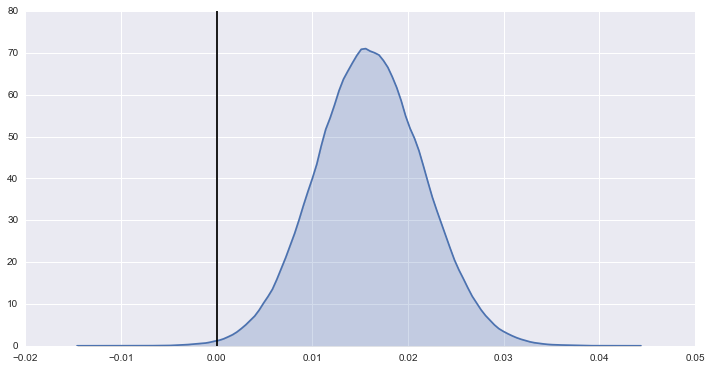

In [67]:
siteA_distribution = mcmc.trace("p_A")[:]
siteB_distribution = mcmc.trace("p_B")[:]
delta_distribution = mcmc.trace('delta')[:]

sns.kdeplot(delta_distribution, shade = True)
plt.axvline(0.00, color = 'black');

In [22]:
print "Probability that website A gets MORE sign-ups than site B: %0.3f" % (delta_distribution < 0).mean()
print "Probability that website A gets LESS sign-ups than site B: %0.3f" % (delta_distribution > 0).mean()

Probability that website A gets MORE sign-ups than site B: 0.023
Probability that website A gets LESS sign-ups than site B: 0.977


## Beta Distribution and Bayesian Priors

In [37]:
support = np.linspace(0,1, 500)[1:-1]

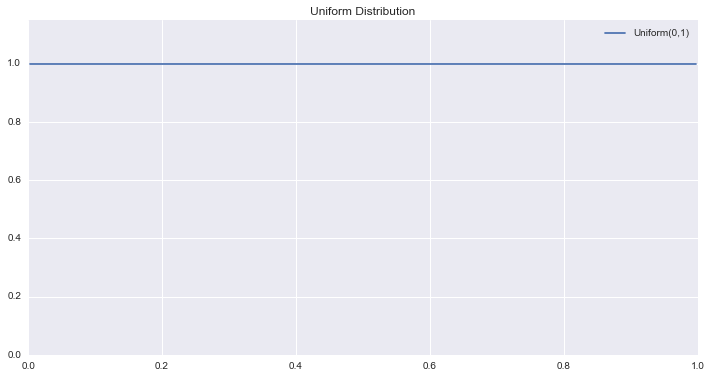

In [41]:
U_01 = uniform()
plt.plot(support, U_01.pdf(support), label = "Uniform(0,1)")
plt.ylim(0,1.15)
plt.legend()
plt.title("Uniform Distribution");
# plt.savefig("results/Uniform.png", format="PNG")

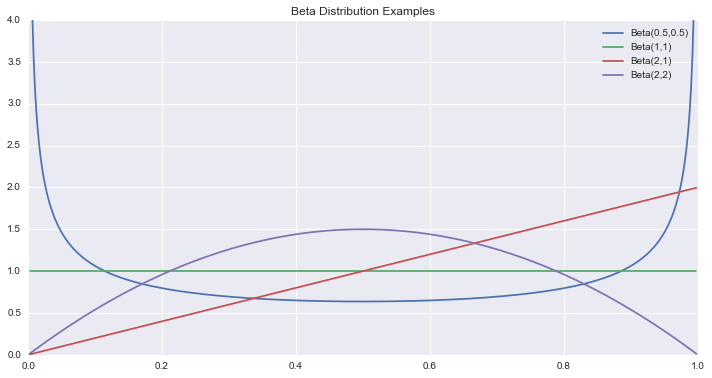

In [48]:
a_vals = [0.5, 1, 2, 2]
b_vals = [0.5, 1, 1, 2]
for a,b in zip(a_vals, b_vals):
    plt.plot(support, beta(a,b).pdf(support), label = "Beta(%s,%s)" %(a,b))
plt.legend()
plt.ylim(0,4)
plt.title("Beta Distribution Examples");
# plt.savefig("results/Beta.png", format="PNG")

In [49]:
@pymc.stochastic(dtype=np.float64)
def beta_priors(value=[1.0, 1.0]):
    a, b = value
    if a <= 0 or b <= 0:
        return -np.inf
    else:
        return np.log(np.power((a + b), -2.5))

a = beta_priors[0]
b = beta_priors[1]

In [69]:
# The hidden, true rate for each website.
true_rates = pymc.Beta('true_rates', a, b, size=5)

# The observed values
trials = np.array([1055, 1057, 1065, 1039, 1046])
successes = np.array([28, 45, 69, 58, 60])
observed_values = pymc.Binomial('observed_values', trials, true_rates, observed=True, value=successes)

model = pymc.Model([a, b, true_rates, observed_values])
mcmc = pymc.MCMC(model)

# Generate 1,000,000 samples, and throw out the first 500,000
mcmc.sample(1000000, 500000)

 [-----------------100%-----------------] 1000000 of 1000000 complete in 281.4 sec

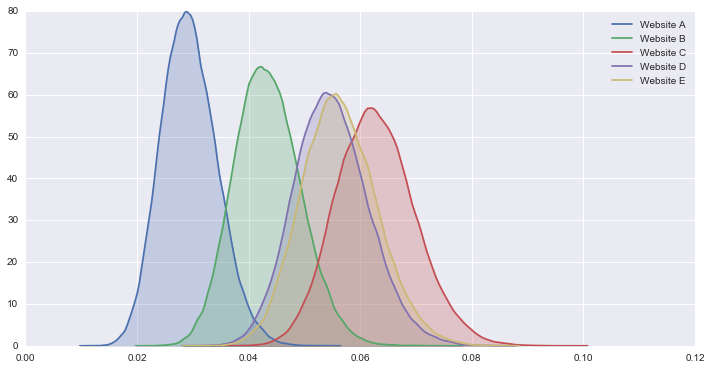

In [70]:
for i in range(5):
    sns.kdeplot(mcmc.trace('true_rates')[:][:,i], shade = True, label = "Website %s" % chr(65+i))

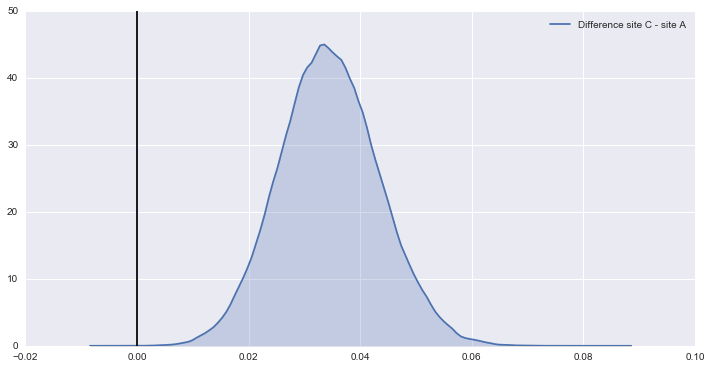

In [53]:
diff_CA = mcmc.trace('true_rates')[:][:,2] - mcmc.trace('true_rates')[:][:,0]
sns.kdeplot(diff_CA, shade = True, label = "Difference site C - site A")
plt.axvline(0.0, color = 'black');

In [54]:
print "Probability that website A gets MORE sign-ups than website C: %0.3f" % (diff_CA < 0).mean()
print "Probability that website A gets LESS sign-ups than website C: %0.3f" % (diff_CA > 0).mean()

Probability that website A gets MORE sign-ups than website C: 0.000
Probability that website A gets LESS sign-ups than website C: 1.000


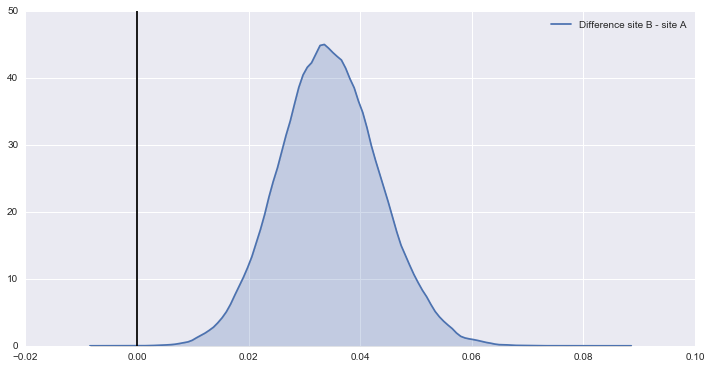

In [55]:
diff_BA = mcmc.trace('true_rates')[:][:,1] - mcmc.trace('true_rates')[:][:,0]
sns.kdeplot(diff_CA, shade = True, label = "Difference site B - site A")
plt.axvline(0.0, color = 'black')

In [56]:
print "Probability that website A gets MORE sign-ups than website B: %0.3f" % (diff_BA < 0).mean()
print "Probability that website A gets LESS sign-ups than website B: %0.3f" % (diff_BA > 0).mean()

Probability that website A gets MORE sign-ups than website B: 0.029
Probability that website A gets LESS sign-ups than website B: 0.971


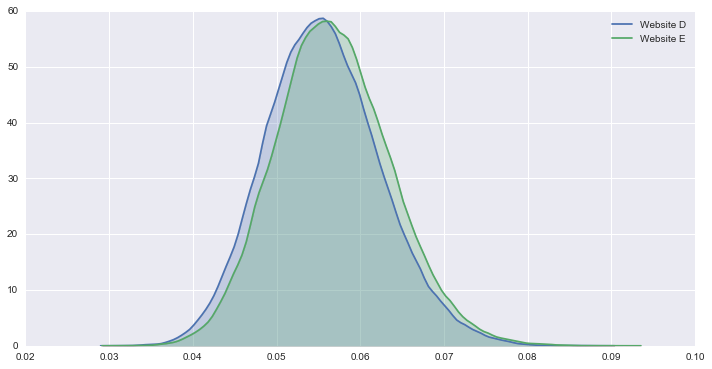

In [57]:
for i in range(3,5):
    sns.kdeplot(mcmc.trace('true_rates')[:][:,i], shade = True, label = "Website %s" % chr(65+i))

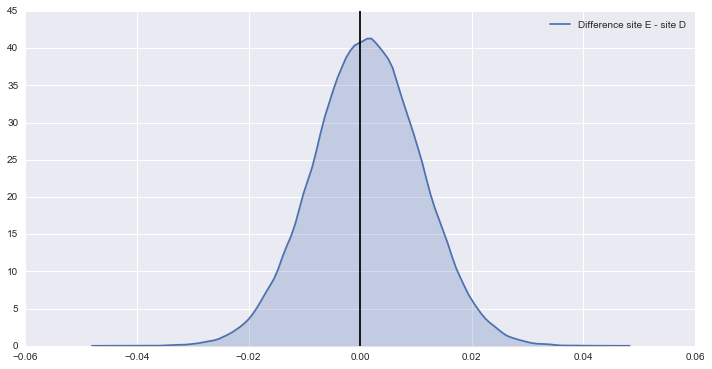

In [59]:
diff_ED = mcmc.trace('true_rates')[:][:,4] - mcmc.trace('true_rates')[:][:,3]
sns.kdeplot(diff_ED, shade = True, label = "Difference site E - site D")
plt.axvline(0.0, color = 'black');

In [60]:
print "Probability that website D gets MORE sign-ups than website E: %0.3f" % (diff_ED < 0).mean()
print "Probability that website D gets LESS sign-ups than website E: %0.3f" % (diff_ED > 0).mean()

Probability that website D gets MORE sign-ups than website E: 0.449
Probability that website D gets LESS sign-ups than website E: 0.551


## Comparing the two methods

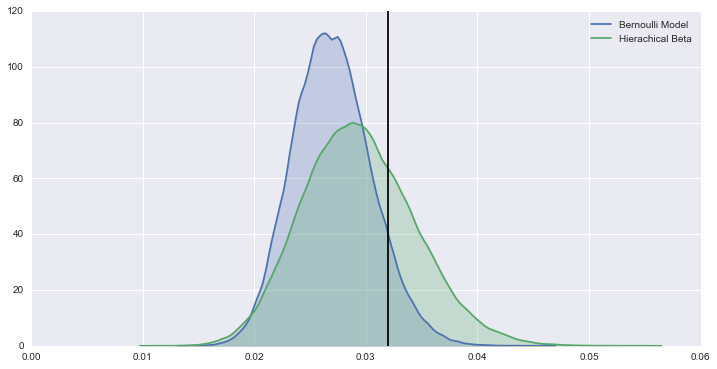

In [83]:
sns.kdeplot(siteA_distribution, shade = True, label = "Bernoulli Model")
sns.kdeplot(mcmc.trace('true_rates')[:][:,0], shade = True, label = "Hierachical Beta")
plt.axvline(0.032, color = 'black')